In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1).astype("float32") / 255.
x_test = np.expand_dims(x_test, axis=-1).astype("float32") / 255.

In [27]:
input_img = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(64, (3, 3), activation='swish', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='swish', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


In [28]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


In [32]:
def ssim_loss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def l1_ssim_loss(y_true, y_pred, alpha=0.5):
    l1 = tf.reduce_mean(tf.abs(y_true - y_pred))

    calculated_ssim_loss = ssim_loss(y_true, y_pred)

    return alpha * l1 + (1 - alpha) * calculated_ssim_loss

In [33]:
autoencoder = models.Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer='adam', loss = lambda y_true, y_pred: l1_ssim_loss(y_true, y_pred, alpha=0.4))
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
es = EarlyStopping(monitor = 'loss', patience = 10, restore_best_weights=True)

history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=64,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[es]
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.3126 - val_loss: 0.2051
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.1956 - val_loss: 0.1833
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1792 - val_loss: 0.1741
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1727 - val_loss: 0.1703
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1676 - val_loss: 0.1677
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1647 - val_loss: 0.1644
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1618 - val_loss: 0.1624
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1604 - val_loss: 0.1612
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1593 - val_loss: 0.1600
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1581 - val_loss: 0.1594
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1566 - val_loss: 0.1585
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


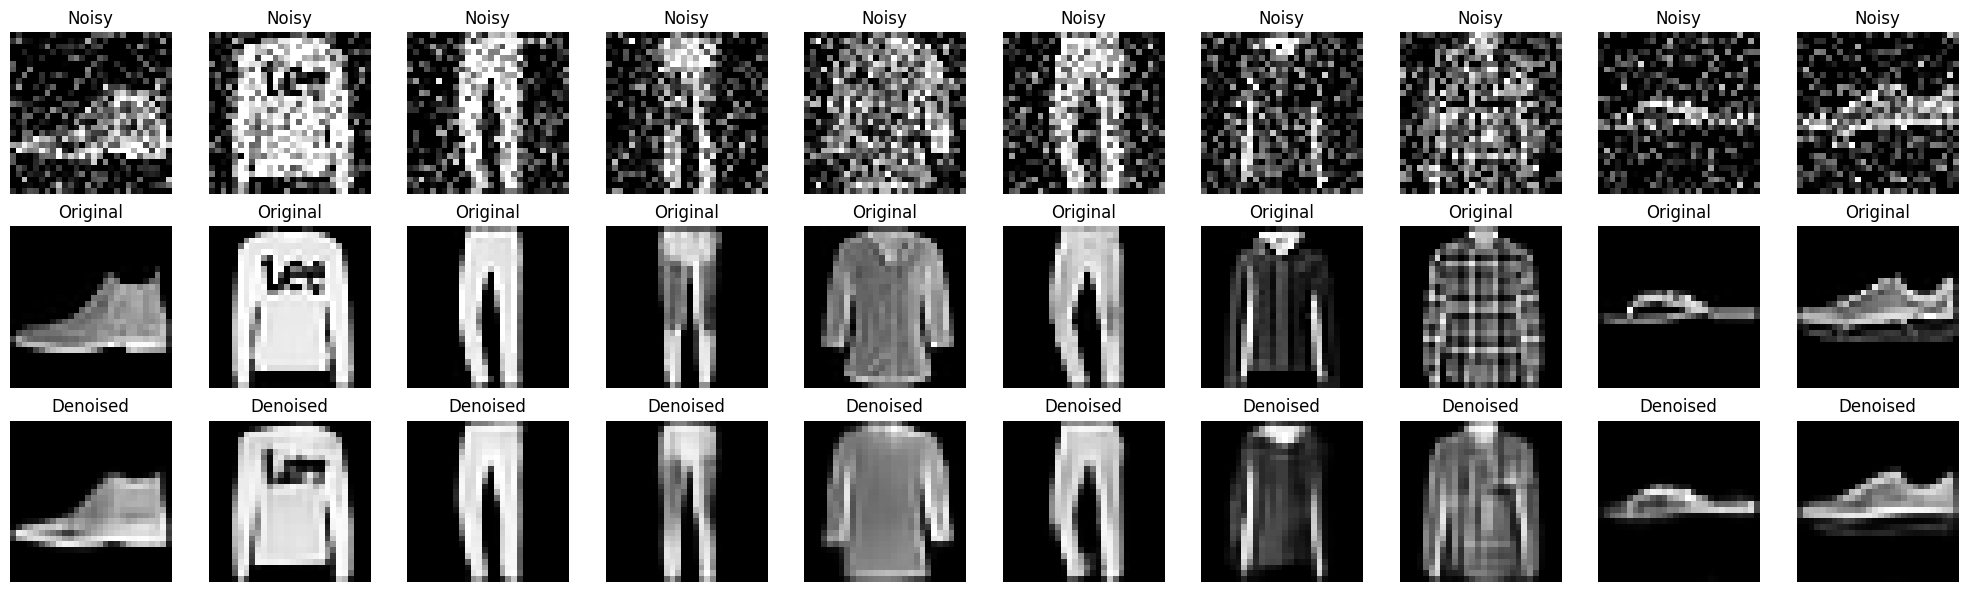

In [35]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.tight_layout()
plt.show()


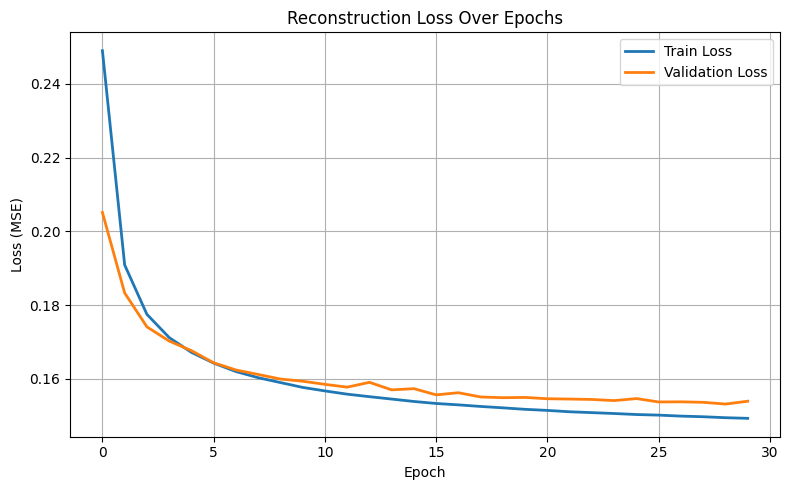

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


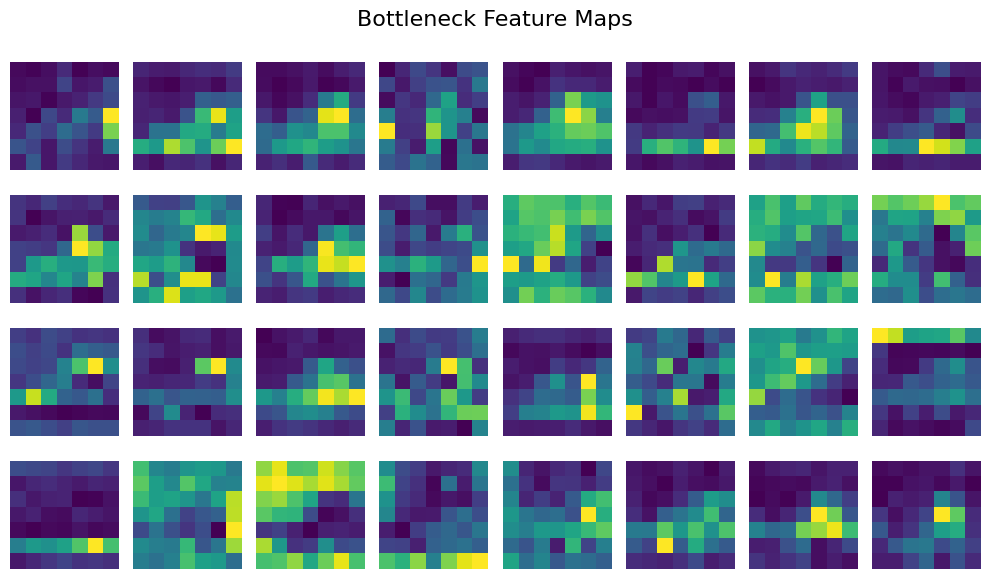

In [37]:
encoder = tf.keras.Model(inputs=autoencoder.input, outputs=encoded)

bottleneck_features = encoder.predict(x_test_noisy[:10])

plt.figure(figsize=(10, 6))
num_features_to_display = min(bottleneck_features.shape[-1], 32)
for i in range(num_features_to_display):
    ax = plt.subplot(4, 8, i+1)
    plt.imshow(bottleneck_features[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.suptitle("Bottleneck Feature Maps", fontsize=16)
plt.tight_layout()
plt.show()

# Autoencoder for Fashion MNIST – Summary and Learnings

##  Model Summary

This project implements a **Convolutional Denoising Autoencoder** to remove noise from grayscale images in the **Fashion MNIST** dataset. The model takes noisy images as input and attempts to reconstruct clean versions of them. Key features include:

- Use of **convolutional layers** for spatial feature extraction
- **SSIM + L1 loss** for perceptual and pixel-wise accuracy
- **EarlyStopping** to prevent overfitting
- **Bottleneck visualization** for latent representation insight
- **Training on noisy images** for robust denoising

---

## Model Architecture

- **Input Shape**: `(28, 28, 1)`
- **Encoder**:
  - `Conv2D(32)` → `MaxPooling2D`
  - `Conv2D(64)` → `MaxPooling2D`
- **Bottleneck**:
  - Low-dimensional latent representation
- **Decoder**:
  - `Conv2D(64)` → `UpSampling2D`
  - `Conv2D(32)` → `UpSampling2D`
  - `Conv2D(1)` with `sigmoid` activation for reconstruction

---

##  Training and Optimization

- **Dataset**: Fashion MNIST (grayscale clothing images)
- **Noise Injection**: Gaussian noise added to input, clipped between 0 and 1
- **Loss Function**: 
  - Combination of **L1 loss** (Mean Absolute Error)
  - and **SSIM loss** (Structural Similarity Index)
- **Optimizer**: Adam
- **Callbacks**: `EarlyStopping(patience=5, restore_best_weights=True)`
- **Metrics**: Visualization of reconstruction quality and training/validation loss

---

##  Learnings

- Convolutional layers effectively preserve spatial structure and outperform dense layers in image reconstruction tasks.
- Combining **L1 + SSIM loss** leads to more visually accurate outputs compared to using MSE or BCE alone.
- **Early stopping** helps retain the best model and avoid overfitting, especially on small or clean datasets.
- Adding noise during training makes the autoencoder more resilient and encourages learning robust features.
- The **bottleneck layer** helps in understanding compressed representations and can be reused for tasks like clustering or anomaly detection.

---
